In [2]:
import pandas as pd
from csv import writer
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
import time
from bs4 import BeautifulSoup
import json
from datetime import datetime


In [ ]:
# SOMMAIRE
# 1. Collecte de données - Webscraping
# 2. Analyse exploratoire des données 
# 3. Transformation des données : Mise à l'échelle des variables etc
# 4. Classification multi-classes - Machine Learning
# 5. Deep learning 

In [2]:
from urllib import request

# 1. Collecte de données - Webscraping

def Collecte(Login, Password):

    PATH = r"C:\Users\anass.kamalidrissi\Downloads\chromedriver.exe"

    driver = webdriver.Chrome(PATH)

    # Adresse du site à scrapper 

    driver.get("https://www.velib-metropole.fr/private/account#/my-runs")
    html = driver.page_source

    soup2 = BeautifulSoup(html)

    # On insère le login/mdp

    inputElement = driver.find_element(By.CLASS_NAME, 'form-control')
    inputElement.send_keys(Login)

    inputElement = driver.find_element(By.NAME, '_password')
    inputElement.send_keys(Password)

    driver.implicitly_wait(10) 

    # On refuse tous les cookies

    driver.find_element(By.XPATH,"//span[@onclick='tarteaucitron.userInterface.respondAll(false);']").click()
    time.sleep(3)


    # click sur recaptcha en passant sur iframe puis en quittant

    WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.CSS_SELECTOR,"iframe[name^='a-'][src^='https://www.google.com/recaptcha/api2/anchor?']")))
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//span[@id='recaptcha-anchor']"))).click()
    driver.switch_to.default_content()

    # cliquer sur se connecter 

    time.sleep(3)
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'btn-smoove-valid'))).click()

    # click sur voir mes trajets

    time.sleep(3)
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'btn-smoove-valid'))).click()


    # Il existe une webapi privée donc on l'exploite pour récupérer tous les trajets

    driver.get("https://www.velib-metropole.fr/webapi/private/getCourseList?limit=10000&offset=0")
    JSON_api = driver.page_source

    # driver.quit()
    return JSON_api 

In [7]:
# On transforme le JSON en dictionnaire python
def transf(JSON_api):
    soup = BeautifulSoup(JSON_api).text
    dict = json.loads(soup)
    return dict  

In [8]:
# On récupère les données du premier compte puis on fait pareil pour les autres comptes. 
JSON_api = Collecte('XXXXXXXXXX@gmail.com', 'Password')
dict = transf(JSON_api)

In [9]:
#On regarde un trajet pour voir la structure du dictionnaire 

dict["walletOperations"][3]
trajet = dict["walletOperations"][100]
print(trajet)

# On essaye ci-dessous de voir si le "parameter1" correspond à l'information vélo électrique ou mécanique
# il s'avère que oui (en regardant sur le site web avec quelques tests) donc on va utiliser cette info dans nos analyses

for i in range(484):
    ID = dict["walletOperations"][i]['parameter3']['BIKEID']
    if ID == '06324':
        print(dict["walletOperations"][i]['parameter1'])

{'code': '28_V1_CHARGE_USAGE', 'description': "La charge d'usage", 'userAccount': '99881589570100585', 'walletTemplate': 'PRINCIPAL', 'seller': 'VELIB', 'chargeInstance': '28_V1_CHARGE_USAGE', 'chargeInstanceId': 37099664, 'currency': 'EUR', 'status': 'TREATED', 'updated': 1664261223667, 'ratingUnitDescription': 'second', 'taxCode': 'TAX_HIGH', 'taxPercent': 20, 'unitAmountWithoutTax': 0, 'unitAmountWithTax': 0, 'unitAmountTax': 0, 'quantity': 740, 'amountWithoutTax': 0, 'amountWithTax': 0, 'amountTax': 0, 'parameter1': 'yes', 'parameter2': 'TRAJET_USAGE', 'parameter3': {'BIKEID': '34205', 'DISTANCE': '2678.0', 'usageId': '16717395868', 'departureStationId': '11218807773', 'arrivalStationId': '1057203651', 'BILLED_QUANTITY': '0.0', 'OVERCHARGING_QUANTITY': '0.0', 'USED_BONUS': '0.0', 'BONUS_EARNED': '0.0', 'LEFT_BONUS': '15.0', 'SAVED_CARBON_DIOXIDE': 297.3, 'AVERAGE_SPEED': 13}, 'startDate': 1664260469000, 'endDate': 1664261213000, 'operationDate': 1664260469000, 'subscriptionDate': 1

In [10]:
# On essaye de déterminer si "AmountWithTax" correspond au prix quand on dépasse 45 min de vélo, la réponse est oui (1€)
# Les indicateurs "Billed_Quantity" et "overcharging" sont inutiles car ils sont tout le temps à 0 
for i in range(484):
    ID = dict["walletOperations"][i]['parameter3']['BIKEID']
    if ID == '37264':
        print(dict["walletOperations"][i]['amountWithTax'])

0


In [245]:
# On récupère les données fournies par la Webapi dans un excel 

from asyncio.windows_events import NULL

def add_dict(dict):
    with open('Velib_data.csv', 'a+', encoding='utf8', newline='') as f:
        thewriter = writer(f)
        header = ['Distance', 'Carbon', 'id_velo', 'Day', 'Date', 'Starttime', 'Endtime', 'avg_speed', 
        'Electric', 'Surcharge', 'Billed_for_ride', 'Overcharged_for_ride', 'Cyclist']
        thewriter.writerow(header)

        # Il faudrait développer une variable pour récupérer le nombre total des trajets à chaque fois sans le chercher manuellement
        for i in range (0, 420):
            trajet = dict["walletOperations"][i]
            Distance = trajet['parameter3']['DISTANCE']
            Carbon = trajet['parameter3']['SAVED_CARBON_DIOXIDE']
            id_velo = trajet['parameter3']['BIKEID']
            Electric = trajet['parameter1']
            Surcharge = trajet['amountWithTax']

            # On récupère les timestamp sous format unix et on les transforme en format de date compréhensible
            Startdate = trajet['startDate']/1000
            Day = datetime.utcfromtimestamp(Startdate).strftime('%A')
            Date = datetime.utcfromtimestamp(Startdate).strftime('%d-%m-%Y')
            Starttime = datetime.utcfromtimestamp(Startdate).strftime('%H:%M:%S')


            Enddate = trajet['endDate']/1000
            Endtime = datetime.utcfromtimestamp(Enddate).strftime('%H:%M:%S')

            avg_speed = trajet['parameter3']['AVERAGE_SPEED']
            Cyclist = 'Cyclist C'

            #Les deux variables suivantes ne sont pas toujours présentes, donc on estime que c'est 0 en cas d'absence
            # Probablement inutiles mais on les garde pour l'instant
            try: 
                Billed_for_ride = trajet['parameter3']['BILLED_QUANTITY']
            except: 
                Billed_for_ride = '0'
        
            try: 
                Overcharged_for_ride = trajet['parameter3']['OVERCHARGING_QUANTITY']
            except: 
                Overcharged_for_ride = '0'
                
            # On écrit les lignes dans le fichier avec ces variables
            info = [Distance, Carbon, id_velo, Day, Date, Starttime, Endtime,
            avg_speed, Electric, Surcharge, Billed_for_ride, Overcharged_for_ride, Cyclist]
            thewriter.writerow(info)

In [4]:
# On récupère le csv sous Pandas
PATH_csv = r"C:\Users\anass.kamalidrissi\.vscode\Velib_data.csv"
df = pd.read_csv(PATH_csv)

df.head()



,Distance,Carbon,id_velo,Day,Date,Starttime,Endtime,avg_speed,Electric,Surcharge,Billed_for_ride,Overcharged_for_ride,Cyclist
0,1592.0,176.7,50675.0,Sunday,02-10-2022,11:39:07,11:46:20,13.1,no,0,0.0,0.0,Cyclist A
1,1427.0,158.4,13331.0,Sunday,02-10-2022,10:01:07,10:07:55,12.7,no,0,0.0,0.0,Cyclist A
2,10061.0,1116.8,30128.0,Saturday,01-10-2022,22:21:29,23:00:21,15.6,yes,0,0.0,0.0,Cyclist A
3,2267.0,251.6,5767.0,Friday,30-09-2022,20:30:34,20:41:16,13.1,yes,0,0.0,0.0,Cyclist A
4,2934.0,325.7,10300.0,Friday,30-09-2022,18:40:14,18:52:42,14.2,yes,0,0.0,0.0,Cyclist A


In [3]:
# 2. Analyse exploratoire de données 

df.shape

(1867, 13)

In [80]:
df[['Distance','avg_speed']].describe()

,Distance,avg_speed
count,1867.000000,1867.000000
mean,3307.355651,11.392180
std,3415.849348,6.008262
min,0.000000,0.000000
25%,830.000000,7.150000
50%,2551.000000,12.900000
75%,4371.000000,15.900000
max,24650.000000,26.600000


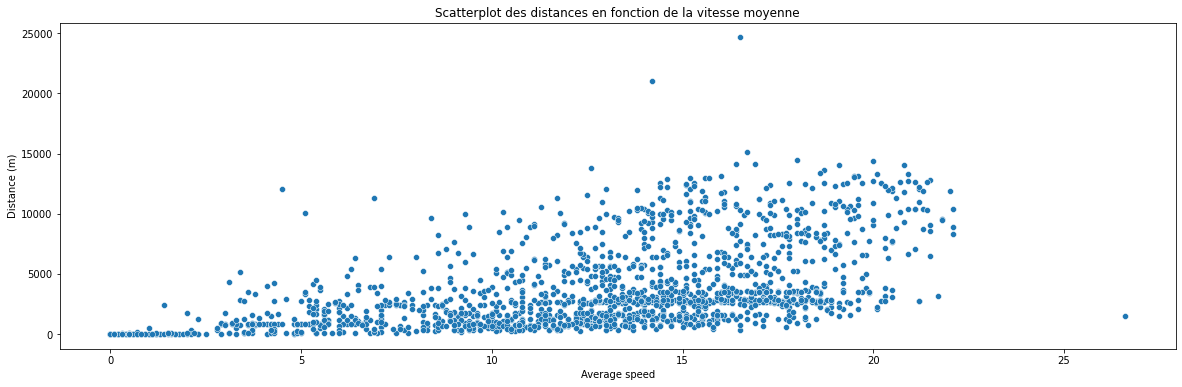

In [6]:
# On affiche un scatterplot de la distance en fonction de la vitesse moyenne de tous les trajets

sns.scatterplot(df['avg_speed'], df['Distance'])
plt.xlabel('Average speed')
plt.ylabel('Distance (m)')
plt.title('Scatterplot des distances en fonction de la vitesse moyenne')
plt.rcParams["figure.figsize"] = (20,6)
plt.show()


Text(0.5, 1.0, 'Boxplot des vitesses moyennes')

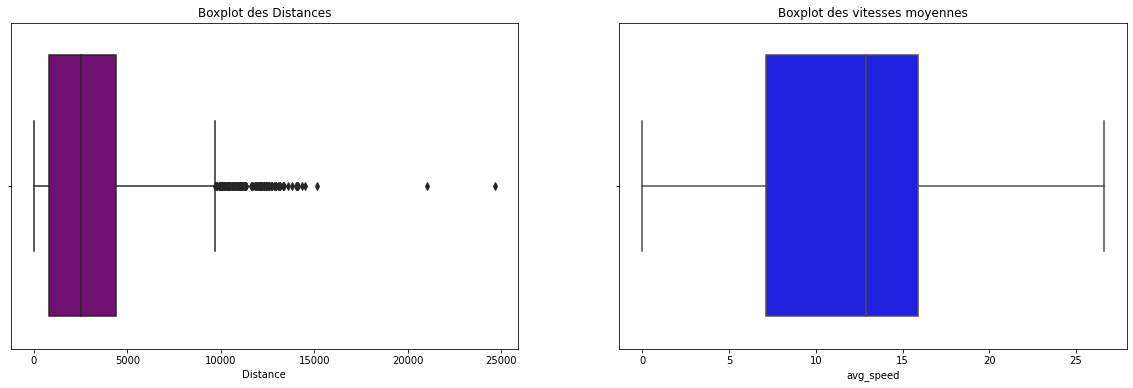

In [81]:
# Boxplots pour voir les valeurs aberrantes

f, axes = plt.subplots(ncols =2, figsize=(20,6))

sns.boxplot(df['Distance'], ax=axes[0], color='purple')
axes[0].set_title('Boxplot des Distances')

sns.boxplot(df['avg_speed'], ax=axes[1], color='blue')
axes[1].set_title('Boxplot des vitesses moyennes')


Text(0.5, 1.0, 'Distribution des vitesses moyennes')

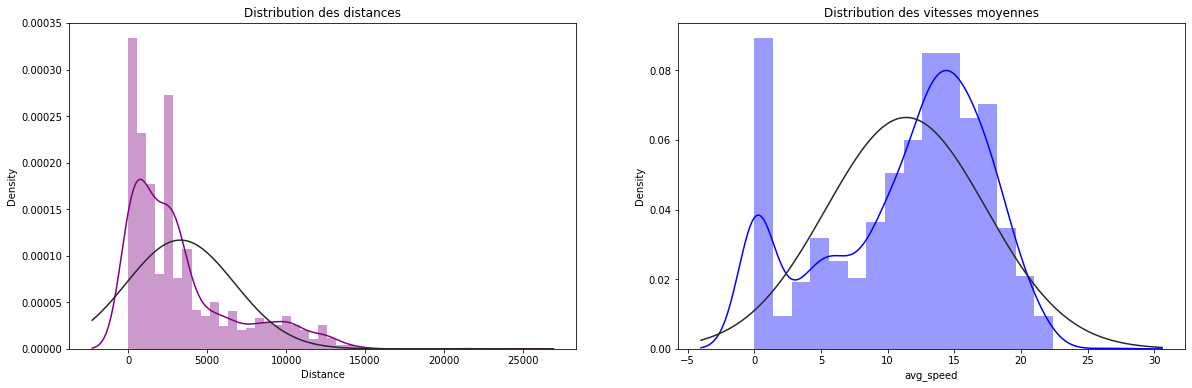

In [87]:

f, axes = plt.subplots(ncols =2, figsize=(20,6))

sns.distplot(df['Distance'], ax=axes[0] , fit=norm, color='purple')
axes[0].set_title('Distribution des distances')

sns.distplot(df['avg_speed'], ax=axes[1], fit=norm, color='blue')
axes[1].set_title('Distribution des vitesses moyennes')

# Il y'a beaucoup de trajets avec une vitesse moyenne proche de 0. Si on enlève ces valeurs on pourrait s'approcher d'une distribution normale 

In [39]:
# Proportions de trajets par Cycliste 

df.groupby('Cyclist').agg(count=('Cyclist', 'count'))

# Le cycliste B est sur-représenté dans le dataset. 
# Une piste à considérer est de sous-échantilloner le Cyclist B afin d'avoir des proportions équilibrées entre les 3 cyclistes. 

,count
Cyclist,
Cyclist A,487
Cyclist B,960
Cyclist C,420


le pourcentage de vélos en panne est de : 18.75 %


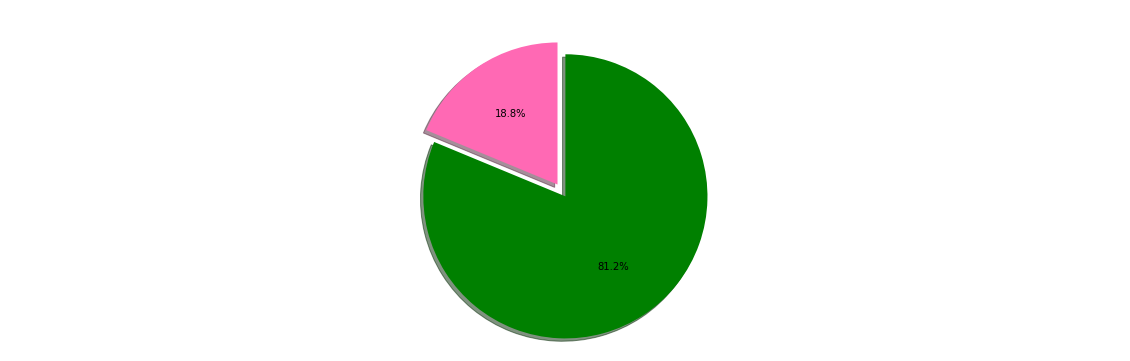

In [124]:
# Nous allons calculer le pourcentage des vélos pris qui étaient en panne (Moins de 500 mètres parcourus => remis en station)

Distances = df['Distance'] 
Pannes = [x for x in Distances if x < 500]

prct_pannes = round(len(Pannes)*100/len(Distances),2)
print(f"le pourcentage de vélos en panne est de : {prct_pannes} %")


# 18.75% des vélos étaient en panne, sachant qu'on examine l'état des vélos à l'oeil avant de prendre le vélo.
# Le vrai taux de panne pourrait atteindre 30 ou 40% puisque les sations sont souvent déconnectées entièrement 

# Pie chart
labels = 'En panne', 'Fonctionnels'
sizes = [prct_pannes, 100-prct_pannes]
colors =['hotpink','green']
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, pcts = ax1.pie(
    sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=90
    )

for text in texts:
    text.set_color('white')
plt.setp(texts, fontweight=600,fontsize=12)
ax1.axis('equal')
ax1.set_title('Pourcentage de vélibs en panne', color='white', fontsize=18)

plt.show()

In [131]:
#On va enlever les distances en dessous de 500mètres (Vélos en panne), puis on va comparer les vitesses moyennes et les distances moyennes des trois cyclistes

Cyclists = ['Cyclist A', 'Cyclist B', 'Cyclist C']

for Cyclist in Cyclists:
    df_Cyclist_electric = df[df['Cyclist'] == Cyclist][df['Distance'] > 500][df['Electric'] == 'yes']
    df_Cyclist_mechanical = df[df['Cyclist'] == Cyclist][df['Distance'] > 500][df['Electric'] == 'no']
    avg_electric = round(df_Cyclist_electric['avg_speed'].mean(),2)
    avg_elec_dist = round(df_Cyclist_electric['Distance'].mean(),2)
    avg_mech = round(df_Cyclist_mechanical['avg_speed'].mean(),2)
    avg_mech_dist = round(df_Cyclist_mechanical['Distance'].mean(),2)
    print(
        f" {Cyclist} Vitesse moyenne en électrique : {avg_electric}, distance moyenne en électrique : {avg_elec_dist}"
        f" Vitesse moyenne en mécanique : {avg_mech}, Distance moyenne en mécanique : {avg_mech_dist} "
        )
#On remarque qu'il y'a des différences entre les trois cyclistes, surtout pour la distance.
#Ce seront des variables utiles pour nos modèles

 Cyclist A Vitesse moyenne en électrique : 14.29, distance moyenne en électrique : 2527.77 Vitesse moyenne en mécanique : 11.35, Distance moyenne en mécanique : 2022.25 
 Cyclist B Vitesse moyenne en électrique : 15.72, distance moyenne en électrique : 5632.52 Vitesse moyenne en mécanique : 11.36, Distance moyenne en mécanique : 4882.85 
 Cyclist C Vitesse moyenne en électrique : 14.2, distance moyenne en électrique : 3543.01 Vitesse moyenne en mécanique : 10.69, Distance moyenne en mécanique : 1162.39 


Text(0.5, 1.0, 'Cycliste C - utilisation sur la semaine')

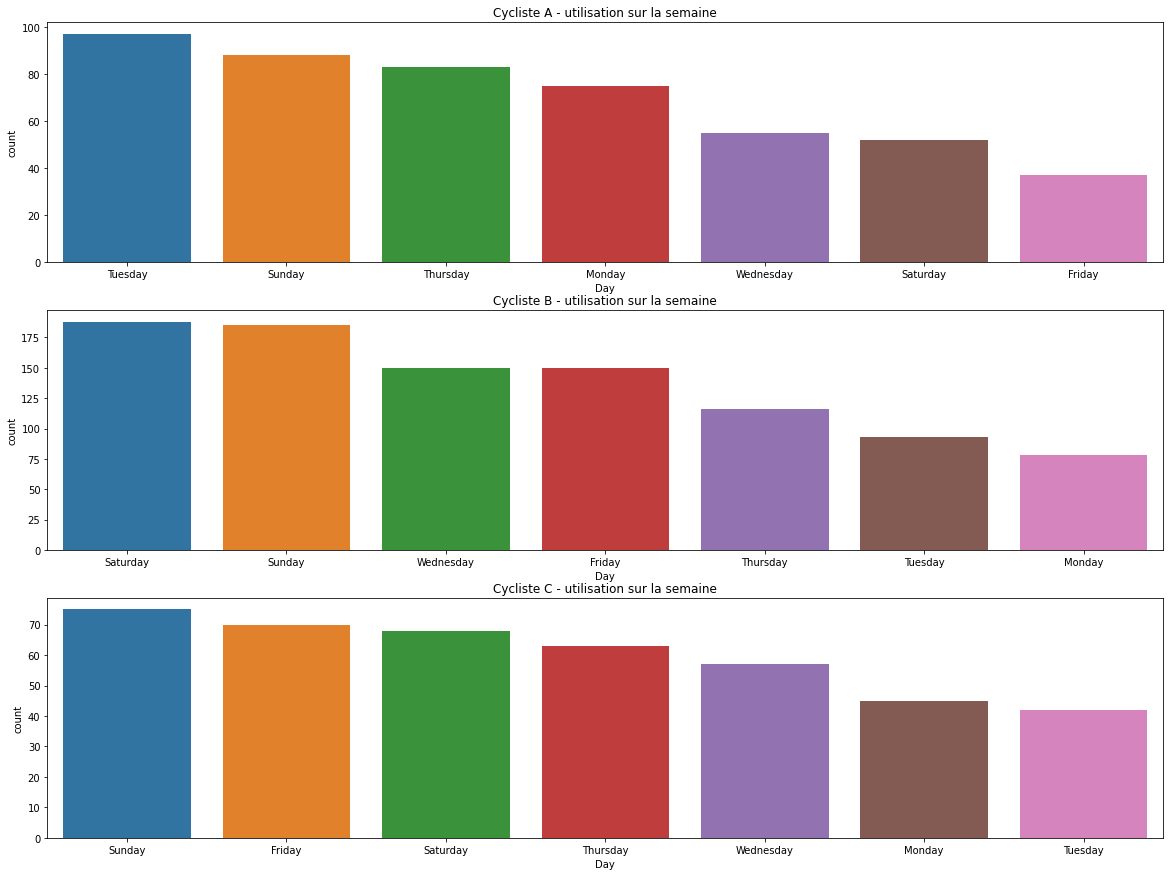

In [25]:
#Nous avons des tendances d'utilisation assez différentes sur les jours de la semaine, ce sera probablement une bonne variable pour les prédictions 
df_CyclistA = df[df['Cyclist'] == 'Cyclist A']
df_CyclistB = df[df['Cyclist'] == 'Cyclist B']
df_CyclistC = df[df['Cyclist'] == 'Cyclist C']

f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize =(20,15))

sns.countplot(df_CyclistA['Day'], ax=ax1, order =df_CyclistA['Day'].value_counts().index)
ax1.set_title('Cycliste A - utilisation sur la semaine')

sns.countplot(df_CyclistB['Day'], ax=ax2, order =df_CyclistB['Day'].value_counts().index)
ax2.set_title('Cycliste B - utilisation sur la semaine')

sns.countplot(df_CyclistC['Day'], ax=ax3, order =df_CyclistC['Day'].value_counts().index)
ax3.set_title('Cycliste C - utilisation sur la semaine')

In [26]:
# Combien de fois le Cycliste B a utilisé le même vélib plusieurs fois 

df[df['Cyclist'] == 'Cyclist B']['id_velo'].value_counts().loc[lambda x : x>2].to_frame()

,id_velo
17050.0,4
45848.0,4
16605.0,4
42996.0,4
44737.0,3
11855.0,3
39461.0,3
51123.0,3
11978.0,3
38372.0,3


In [40]:
# 3. Transformation des données

#Supprimer les faux trajets qui correspondent aux vélos en panne  

df_new = df[df['Distance'] > 500]

In [49]:
# Supprimer les distances aberrantes 

dist_stat = df_new['Distance'].describe()

print(dist_stat)

Q1 = dist_stat[4]
Q3 = dist_stat[6]
IQR = Q3-Q1
upper_bound = Q3 +1.5*IQR
lower_bound = Q1 -1.5*IQR

print(upper_bound)
print(lower_bound)

# On n'aura pas besoin de la borne inférieure

count     1517.000000
mean      4052.646671
std       3375.284271
min        504.000000
25%       1571.000000
50%       2786.000000
75%       5543.000000
max      24650.000000
Name: Distance, dtype: float64
11501.0
-4387.0


In [54]:
df_new = df_new[df_new['Distance'] < upper_bound]
df_new.count()

Distance                1452
Carbon                  1452
id_velo                 1447
Day                     1452
Date                    1452
Starttime               1452
Endtime                 1452
avg_speed               1452
Electric                1452
Surcharge               1452
Billed_for_ride         1452
Overcharged_for_ride    1452
Cyclist                 1452
dtype: int64

In [55]:
# Les valeurs nulles correspondent à la variable id_velo, ce n'est pas embêtant puisqu'on l'utilisera pas dans la suite
df_new.isnull().sum()

Distance                0
Carbon                  0
id_velo                 5
Day                     0
Date                    0
Starttime               0
Endtime                 0
avg_speed               0
Electric                0
Surcharge               0
Billed_for_ride         0
Overcharged_for_ride    0
Cyclist                 0
dtype: int64

Text(0.5, 1.0, 'Boxplot des vitesses moyennes')

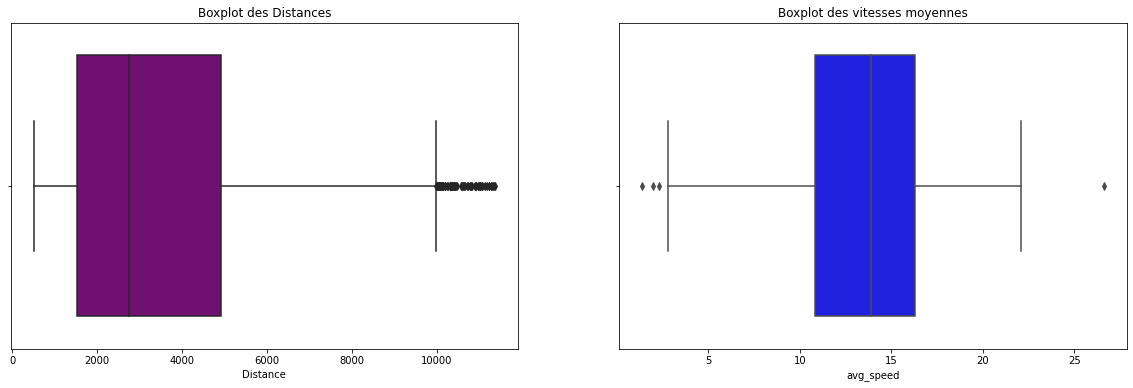

In [56]:
# Boxplots après avoir supprimé les valeurs aberrantes

f, axes = plt.subplots(ncols =2, figsize=(20,6))

sns.boxplot(df_new['Distance'], ax=axes[0], color='purple')
axes[0].set_title('Boxplot des Distances')

sns.boxplot(df_new['avg_speed'], ax=axes[1], color='blue')
axes[1].set_title('Boxplot des vitesses moyennes')


Text(0.5, 1.0, 'Distribution des vitesses moyennes')

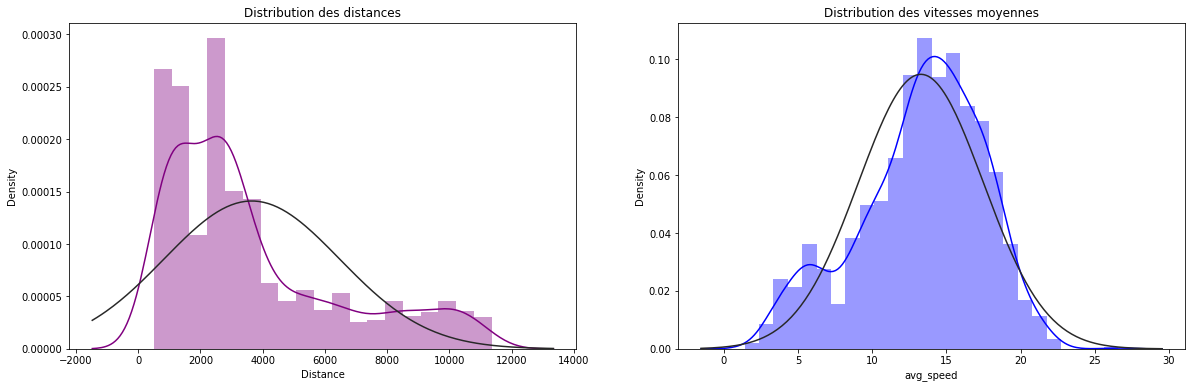

In [57]:
# Distributions 
# La vitesse moyenne s'approche d'une distribution normale 
# Les distances ne suivent pas une distribution normale 

f, axes = plt.subplots(ncols =2, figsize=(20,6))

sns.distplot(df_new['Distance'], ax=axes[0] , fit=norm, color='purple')
axes[0].set_title('Distribution des distances')

sns.distplot(df_new['avg_speed'], ax=axes[1], fit=norm, color='blue')
axes[1].set_title('Distribution des vitesses moyennes')

In [66]:
print("Skewness : L'asymétrie vitesse moy: %f" % df_new['avg_speed'].skew())
print("Kurtosis : L'aplatissement vitesse moy: %f\n" % df_new['avg_speed'].kurt())

print("Skewness : L'asymétrie distances: %f" % df_new['Distance'].skew())
print("Kurtosis : L'aplatissement distances: %f" % df_new['Distance'].kurt())


Skewness : L'asymétrie vitesse moy: -0.491932
Kurtosis : L'aplatissement vitesse moy: -0.239939

Skewness : L'asymétrie distances: 1.145136
Kurtosis : L'aplatissement distances: 0.280709


In [77]:
# On va transformer la colonne des heures pour l'utiliser comme variable pour notre modèle
df_new = df.assign(Hours = df_new['Starttime'].str[:2])

In [90]:
df_new.head()

,Distance,Carbon,id_velo,Day,Date,Starttime,Endtime,avg_speed,Electric,Surcharge,Billed_for_ride,Overcharged_for_ride,Cyclist,Hours,scaled_distance,scaled_avg_speed
0,1592.0,176.7,50675.0,Sunday,02-10-2022,11:39:07,11:46:20,13.1,no,0,0.0,0.0,Cyclist A,11,-0.270827,0.022857
1,1427.0,158.4,13331.0,Sunday,02-10-2022,10:01:07,10:07:55,12.7,no,0,0.0,0.0,Cyclist A,10,-0.317424,-0.022857
2,10061.0,1116.8,30128.0,Saturday,01-10-2022,22:21:29,23:00:21,15.6,yes,0,0.0,0.0,Cyclist A,22,2.120870,0.308571
3,2267.0,251.6,5767.0,Friday,30-09-2022,20:30:34,20:41:16,13.1,yes,0,0.0,0.0,Cyclist A,20,-0.080203,0.022857
4,2934.0,325.7,10300.0,Friday,30-09-2022,18:40:14,18:52:42,14.2,yes,0,0.0,0.0,Cyclist A,18,0.108162,0.148571


In [107]:
# Mise à l'échelle / Scaling

from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

df_new['scaled_distance'] = rob_scaler.fit_transform(df_new['Distance'].values.reshape(-1,1))
df_new['scaled_avg_speed'] = rob_scaler.fit_transform(df_new['avg_speed'].values.reshape(-1,1))
df_new['scaled_hours'] = rob_scaler.fit_transform(df_new['Hours'].values.reshape(-1,1))


In [108]:
df_new[['scaled_distance','scaled_avg_speed','scaled_hours']].describe()

,scaled_distance,scaled_avg_speed,scaled_hours
count,1867.000000,1867.000000,1867.000000
mean,0.213599,-0.172322,-0.227867
std,0.964657,0.686658,0.735572
min,-0.720418,-1.474286,-2.285714
25%,-0.486021,-0.657143,-0.714286
50%,0.000000,0.000000,0.000000
75%,0.513979,0.342857,0.285714
max,6.240892,1.565714,1.000000


In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer

In [109]:
# Data preprocessing 
# On transforme les features catégorique à l'aide d'une pipeline Onehotencoder
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(df_new[['Electric']])

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [110]:
ohe.categories_

[array(['no', 'yes'], dtype=object)]

In [112]:
# On transforme uniquement les colonnes Day et Electric 
column_trans = make_column_transformer(
    (OneHotEncoder(),['Day','Electric']),remainder='passthrough'
)

In [113]:
# pipeline
cols = ['scaled_avg_speed','scaled_distance','Day','Electric','scaled_hours','Cyclist']
column_trans.fit_transform(df_new[cols])

array([[0.0, 0.0, 0.0, ..., -0.27082744987291724, -0.7142857142857143,
        'Cyclist A'],
       [0.0, 0.0, 0.0, ..., -0.31742445636825756, -0.8571428571428571,
        'Cyclist A'],
       [0.0, 0.0, 1.0, ..., 2.120869810787913, 0.8571428571428571,
        'Cyclist A'],
       ...,
       [1.0, 0.0, 0.0, ..., 1.9833380401016663, 0.42857142857142855,
        'Cyclist C'],
       [1.0, 0.0, 0.0, ..., -0.7204179610279582, 0.42857142857142855,
        'Cyclist C'],
       [1.0, 0.0, 0.0, ..., -0.7201355549279864, 0.42857142857142855,
        'Cyclist C']], dtype=object)

In [114]:
from sklearn.pipeline import make_pipeline


In [116]:
# On sépare le Dataset en parties training/test

X = df_new[cols].drop('Cyclist', axis='columns')
y=df_new.Cyclist
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)


In [121]:
# On définit les modèles ML 
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# On évalue les modèles un par un 
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	pipe = make_pipeline(column_trans, model)
	cv_results = cross_val_score(pipe, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

KNN: 0.663794 (0.039128)
LR: 0.618286 (0.029588)
LDA: 0.622975 (0.031790)
KNN: 0.663794 (0.039128)
CART: 0.665199 (0.043105)
NB: 0.608908 (0.041068)
SVM: 0.618949 (0.034668)


In [122]:
pipe.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Day', 'Electric'])])),
                ('svc', SVC(gamma='auto'))])

In [123]:
# On prend un sample de données test pour prédire le cycliste
X_new = X_test.sample(2, random_state=99)

X_new

,scaled_avg_speed,scaled_distance,Day,Electric,scaled_hours
622,0.491429,0.883084,Sunday,yes,-0.428571
1276,0.320000,1.112680,Tuesday,no,0.714286


In [125]:
# Prédiction
pipe.predict(X_new)

array(['Cyclist B', 'Cyclist B'], dtype=object)

In [28]:
# Ce qui peut être envisageable pour la suite est de revisiter les variables/features et supprimer quelques outliers pour optimiser nos algorithmes. 